In [24]:
import math
from math import log, sqrt, exp
from math import erf

# Black–Scholes reference (should be ≈ 9.22701)
bs_ref = bs_call(S0, K, T, r, q, sigma)
print("BS Call:", bs_ref)

# Parameters
S0, K, T = 100.0, 100.0, 1.0
r, q, sigma = 0.05, 0.02, 0.20

#Black–Scholes (European) for the convergence check
def _norm_cdf(x):  # stable Φ(x) without external deps
    return 0.5 * (1.0 + erf(x / sqrt(2.0)))

def bs_call(S0, K, T, r, q, sigma):
    if T <= 0 or sigma <= 0:
        return max(S0 * exp(-q*T) - K * exp(-r*T), 0.0)
    d1 = (log(S0 / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    return S0 * exp(-q * T) * _norm_cdf(d1) - K * exp(-r * T) * _norm_cdf(d2)


#CRR binomial_european
def crr_binomial_european(S0, K, T, r, q, sigma, N, option="call"):
    """
    Cox-Ross-Rubinstein binomial pricer (European), continuous r and q.
    option: "call" or "put"
    """
    dt = T / N
    u = math.exp(sigma * math.sqrt(dt))
    d = 1.0 / u
    disc = math.exp(-r * dt)
    p = (math.exp((r - q) * dt) - d) / (u - d)
    if not (0.0 <= p <= 1.0):
        raise ValueError(f"Risk-neutral prob out of [0,1]: p={p:.6f}. Check inputs.")

    # terminal prices
    ST = [S0 * (u**j) * (d**(N - j)) for j in range(N + 1)]

    # terminal payoffs
    if option.lower() == "call":
        V = [max(s - K, 0.0) for s in ST]
    else:
        V = [max(K - s, 0.0) for s in ST]

    # backward induction
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            V[j] = disc * (p * V[j + 1] + (1 - p) * V[j])

    return V[0]

# If you have bs_call defined earlier:
# bs_ref = bs_call(S0, K, T, r, q, sigma)
# print("BS Call:", bs_ref)

for N in [10, 25, 50, 100, 200, 400, 800, 1600]:
    c_binom = crr_binomial_european(S0, K, T, r, q, sigma, N, option="call")
    # If bs_ref is defined:
    # print(f"N={N:4d}  CRR Call={c_binom:.6f}  |error|={abs(c_binom - bs_ref):.6f}")
    print(f"N={N:4d}  CRR Call={c_binom:.6f}  |error|={abs(c_binom - bs_ref):.6f}")


BS Call: 9.227005508154036
N=  10  CRR Call=9.035326  |error|=0.191680
N=  25  CRR Call=9.301179  |error|=0.074173
N=  50  CRR Call=9.188225  |error|=0.038781
N= 100  CRR Call=9.207590  |error|=0.019416
N= 200  CRR Call=9.217292  |error|=0.009714
N= 400  CRR Call=9.222147  |error|=0.004859
N= 800  CRR Call=9.224576  |error|=0.002430
N=1600  CRR Call=9.225791  |error|=0.001215


,N,delta=T/N,CRR Price,BS Price,|error|,time (s)
0,10,0.100000,9.035326,9.227006,0.191680,0.000368
1,25,0.040000,9.301179,9.227006,0.074173,0.000249
2,50,0.020000,9.188225,9.227006,0.038781,0.000719
3,100,0.010000,9.207590,9.227006,0.019416,0.002512
4,200,0.005000,9.217292,9.227006,0.009714,0.009396
5,400,0.002500,9.222147,9.227006,0.004859,0.035476
6,800,0.001250,9.224576,9.227006,0.002430,0.141497
7,1600,0.000625,9.225791,9.227006,0.001215,0.574290


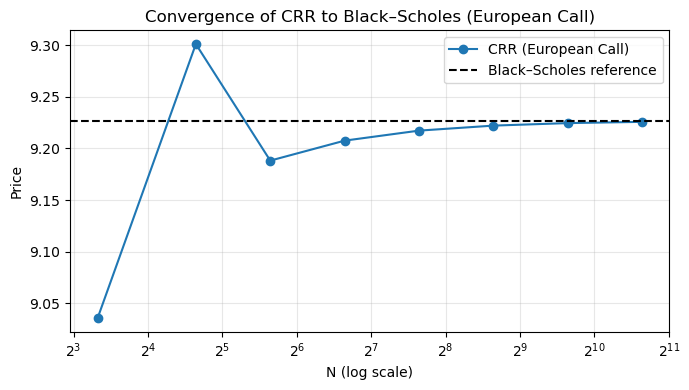

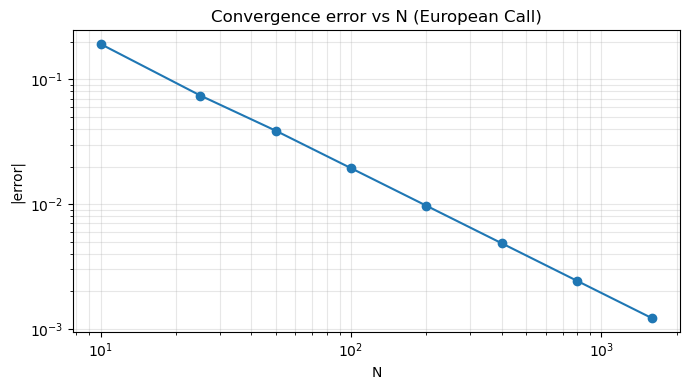

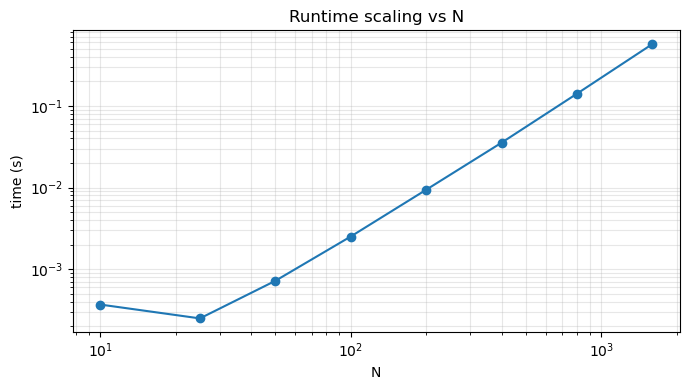

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import perf_counter

Ns = np.array([10, 25, 50, 100, 200, 400, 800, 1600], dtype=int)
prices, errors, times = [], [], []

for N in Ns:
    t0 = perf_counter()
    c_bin = crr_binomial_european(S0, K, T, r, q, sigma, N, option="call")
    times.append(perf_counter() - t0)
    prices.append(c_bin)
    errors.append(abs(c_bin - bs_ref))

delta = T / Ns

df = pd.DataFrame({
    "N": Ns,
    "delta=T/N": delta,
    "CRR Price": np.round(prices, 6),
    "BS Price": np.full_like(Ns, bs_ref, dtype=float),
    "|error|": np.round(errors, 6),
    "time (s)": np.round(times, 6),
})
display(df)

# --- Plot: CRR and BS price vs N ---
plt.figure(figsize=(7,4))
plt.plot(Ns, prices, 'o-', label='CRR (European Call)')
plt.axhline(bs_ref, color='k', ls='--', label='Black–Scholes reference')
plt.xscale('log', base=2)
plt.xlabel('N (log scale)')
plt.ylabel('Price')
plt.title('Convergence of CRR to Black–Scholes (European Call)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Plot: |error| vs N (log–log) ---
plt.figure(figsize=(7,4))
plt.loglog(Ns, errors, 'o-')
plt.xlabel('N')
plt.ylabel('|error|')
plt.title('Convergence error vs N (European Call)')
plt.grid(True, which='both', alpha=0.3)
plt.tight_layout()
plt.show()

# --- Plot: runtime vs N (log–log) ---
plt.figure(figsize=(7,4))
plt.loglog(Ns, times, 'o-')
plt.xlabel('N')
plt.ylabel('time (s)')
plt.title('Runtime scaling vs N')
plt.grid(True, which='both', alpha=0.3)
plt.tight_layout()
plt.show()


In [26]:
def crr_binomial(S0, K, T, r, q, sigma, N, option="call", exercise="E"):
    """
    General CRR pricer: option in {"call","put"}, exercise in {"E","A"}.
    Continuous r and q.
    """
    dt = T / N
    u = math.exp(sigma * math.sqrt(dt))
    d = 1.0 / u
    disc = math.exp(-r * dt)
    p = (math.exp((r - q) * dt) - d) / (u - d)
    if not (0.0 <= p <= 1.0):
        raise ValueError(f"Risk-neutral prob out of [0,1]: p={p:.6f}. Check inputs.")

    # terminal prices
    ST = [S0 * (u**j) * (d**(N - j)) for j in range(N + 1)]

    # terminal payoffs
    if option.lower() == "call":
        V = [max(s - K, 0.0) for s in ST]
    else:
        V = [max(K - s, 0.0) for s in ST]

    american = (exercise.upper() == "A")

    # backward induction
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            hold = disc * (p * V[j + 1] + (1 - p) * V[j])
            if american:
                S_ij = S0 * (u**j) * (d**(i - j))
                if option.lower() == "call":
                    exercise_val = max(S_ij - K, 0.0)
                else:
                    exercise_val = max(K - S_ij, 0.0)
                V[j] = max(hold, exercise_val)
            else:
                V[j] = hold

    return V[0]


,N,CRR American Put,Benchmark,|error|
0,10,6.560329,6.66069,0.100361
1,25,6.728412,6.66069,0.067722
2,50,6.641549,6.66069,0.019141
3,100,6.651030,6.66069,0.009660
4,200,6.655974,6.66069,0.004716
5,400,6.658334,6.66069,0.002356
6,800,6.659528,6.66069,0.001162
7,1600,6.660108,6.66069,0.000582


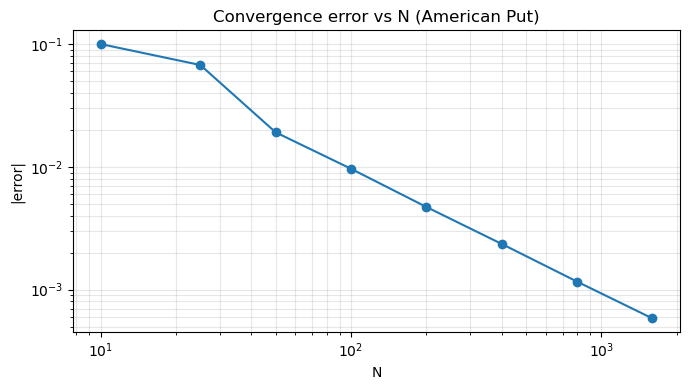

In [27]:
bench_american_put = 6.66069  # given

Ns = np.array([10, 25, 50, 100, 200, 400, 800, 1600], dtype=int)
am_prices, am_errors = [], []

for N in Ns:
    p_bin = crr_binomial(S0, K, T, r, q, sigma, N, option="put", exercise="A")
    am_prices.append(p_bin)
    am_errors.append(abs(p_bin - bench_american_put))

df_put = pd.DataFrame({
    "N": Ns,
    "CRR American Put": np.round(am_prices, 6),
    "Benchmark": np.full_like(Ns, bench_american_put, dtype=float),
    "|error|": np.round(am_errors, 6),
})
display(df_put)

# Plot: |error| vs N (log–log) for American Put
plt.figure(figsize=(7,4))
plt.loglog(Ns, am_errors, 'o-')
plt.xlabel('N')
plt.ylabel('|error|')
plt.title('Convergence error vs N (American Put)')
plt.grid(True, which='both', alpha=0.3)
plt.tight_layout()
plt.show()


,N,CRR American Put,Benchmark,|error|,time (s)
0,10,6.560329,6.66069,0.100361,0.000256
1,25,6.728412,6.66069,0.067722,0.000760
2,50,6.641549,6.66069,0.019141,0.003039
3,100,6.651030,6.66069,0.009660,0.006176
4,200,6.655974,6.66069,0.004716,0.025115
5,400,6.658334,6.66069,0.002356,0.108631
6,800,6.659528,6.66069,0.001162,0.418621
7,1600,6.660108,6.66069,0.000582,1.537785


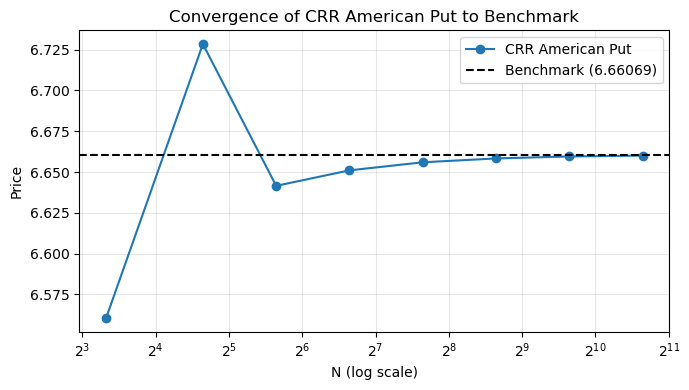

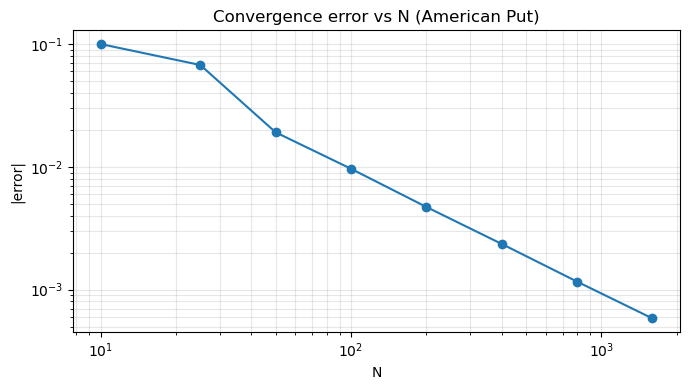

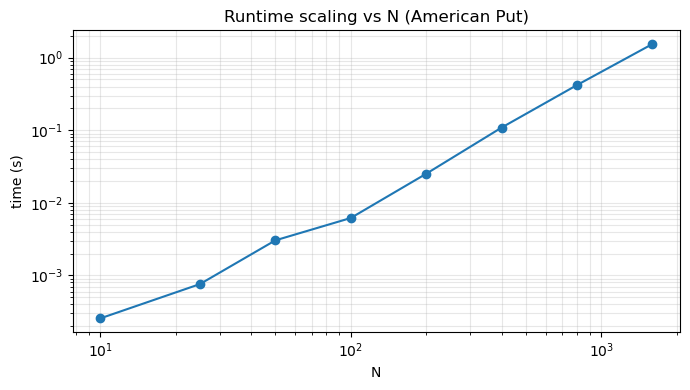

In [28]:
from time import perf_counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

bench_american_put = 6.66069  # given benchmark

Ns = np.array([10, 25, 50, 100, 200, 400, 800, 1600], dtype=int)
am_prices, am_errors, am_times = [], [], []

for N in Ns:
    t0 = perf_counter()
    p_bin = crr_binomial(S0, K, T, r, q, sigma, N, option="put", exercise="A")
    am_times.append(perf_counter() - t0)
    am_prices.append(p_bin)
    am_errors.append(abs(p_bin - bench_american_put))

df_put = pd.DataFrame({
    "N": Ns,
    "CRR American Put": np.round(am_prices, 6),
    "Benchmark": np.full_like(Ns, bench_american_put, dtype=float),
    "|error|": np.round(am_errors, 6),
    "time (s)": np.round(am_times, 6),
})
display(df_put)

# --- Plot 1: Convergence of American Put price vs N ---
plt.figure(figsize=(7,4))
plt.plot(Ns, am_prices, 'o-', label='CRR American Put')
plt.axhline(bench_american_put, color='k', ls='--', label='Benchmark (6.66069)')
plt.xscale('log', base=2)
plt.xlabel('N (log scale)')
plt.ylabel('Price')
plt.title('Convergence of CRR American Put to Benchmark')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Plot 2: |error| vs N (log–log) ---
plt.figure(figsize=(7,4))
plt.loglog(Ns, am_errors, 'o-')
plt.xlabel('N')
plt.ylabel('|error|')
plt.title('Convergence error vs N (American Put)')
plt.grid(True, which='both', alpha=0.3)
plt.tight_layout()
plt.show()

# --- Plot 3: Runtime vs N (log–log) ---
plt.figure(figsize=(7,4))
plt.loglog(Ns, am_times, 'o-')
plt.xlabel('N')
plt.ylabel('time (s)')
plt.title('Runtime scaling vs N (American Put)')
plt.grid(True, which='both', alpha=0.3)
plt.tight_layout()
plt.show()
